# Import libraries

In [56]:
import os
import re
import string
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Tensorflow dependencies ###
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1

### NLTK dependencies ### 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

### Others ###
from sklearn.model_selection import train_test_split

### Some constants ###
english_vocab = set(nltk.corpus.words.words())
BASE_DIR = "./" # "/content/drive/My Drive/"
WEIGHTS_DIR = os.path.join(BASE_DIR, "weights")
MODELS_DIR = os.path.join(BASE_DIR, "models")
BASIC_CNN_MODEL_NAME = "basic_cnn"
COMPLEX_CNN_MODEL_NAME = "complex_cnn"
BASIC_BIRNN_MODEL_NAME = "basic_birnn"

# Loading and preparing data 

In [57]:
### 1. Loading data from files and preprocessing ###
def en_contraction_expand(sentence):
    # Dictionary of English Contractions
    contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    
    return contractions_re.sub(replace, sentence)

def filter_stopwords(text):
    ### Stopword removal using the nltk way ###
    stop_words = set(stopwords.words('english')) # Assuming all nltk data is installed
    lemmatizer = WordNetLemmatizer()
    
    word_tokens = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    filtered_sentence = ' '.join(filtered)
    return filtered_sentence

def preprocess_sentence(sentence):
    # 1. Expand contraction for english
    sentence = en_contraction_expand(sentence)
    
    # 2. Lowercasing text
    sentence = sentence.strip().lower()
    
    # 3. Digits removal
    sentence = re.sub('\w*\d\w*','', sentence)

    # 4. Punctuations removal
    sentence = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    
    # 5. Extra spaces removal
    sentence = re.sub(' +',' ', sentence)
    
    # 6. Filter stopwords 
    sentence = filter_stopwords(sentence)
    
    # 7. Filter non-english words 
    sentence = " ".join(w for w in nltk.wordpunct_tokenize(sentence) \
         if w.lower() in english_vocab or not w.isalpha())
    
    return sentence

def load_data_from_tsv(data_file, test=False):
    start = time.time()
    data = pd.read_table(data_file, header=0)
    
    # Drop unnecessary columns
    dropped_cols = ["PhraseId", "SentenceId"]
    data.drop(dropped_cols, inplace=True, axis=1)
    
    sentences = data['Phrase'].values
    
    if(test):
        sentiments = None
    else:
        sentiments = data['Sentiment'].values
    
    sentences = [preprocess_sentence(x) for x in sentences]
    sentences = np.array(sentences)
    end = time.time()
    
    print(f'[INFO] Took {end - start} seconds to preprocess data from {data_file}')
    
    return sentences, sentiments

X_train, Y_train = load_data_from_tsv("../data/sentiment_train.tsv")
X_test, Y_test  = load_data_from_tsv("../data/sentiment_test.tsv", test=True)

[INFO] Took 25.200551509857178 seconds to preprocess data from ../data/sentiment_train.tsv
[INFO] Took 10.594193696975708 seconds to preprocess data from ../data/sentiment_test.tsv


In [59]:
### 2. Vectorizing data for sentiment analysis ###
tokenizer = Tokenizer(num_words=5000, char_level=False, oov_token="PAD") # 0 is a reserved index
tokenizer.fit_on_texts(np.concatenate([X_train, X_test]))
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq  = tokenizer.texts_to_sequences(X_test)

### Sequence padding ###
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

train_seq = pad(train_seq)
test_seq  = pad(test_seq, length=train_seq.shape[-1])

vocab_size = np.max(np.concatenate([train_seq, test_seq])) + 1
num_classes = len(np.unique(Y_train))

print(f'[INFO] Number of sentences in training set : {train_seq.shape[0]}')
print(f'[INFO] Number of sentences in testing set  : {test_seq.shape[0]}')
print(f'[INFO] Maximum sentence length in          : {train_seq.shape[1]}')
print(f'[INFO] Vocabulary size                     : {vocab_size}')

[INFO] Number of sentences in training set : 156060
[INFO] Number of sentences in testing set  : 66292
[INFO] Maximum sentence length in          : 25
[INFO] Vocabulary size                     : 5000


# Building basic CNN model with 1 Conv layer

In [60]:
def make_simple_cnn_model(input_shape, vocab_size):
    inputs = Input(shape=input_shape[1:])
    embs   = Embedding(vocab_size, 32, input_length=input_shape[1])(inputs)
    embs   = Reshape(target_shape=(input_shape[1], 32))(embs)
    
    conv1d = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embs)
    pool1d = MaxPool1D(pool_size=2)(conv1d)
    
    # return_sequences : whether to return the full sequence of output or only the last output in the sequence
    # return_sequences is defaulted as False.
    rnn    = LSTM(64, return_sequences=False, dropout=0.2,recurrent_dropout=0.2)(pool1d)
    logits = Dense(num_classes)(rnn)
    output = Activation("softmax")(logits)
    
    model  = Model(inputs=inputs, outputs=output, name=BASIC_CNN_MODEL_NAME)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

train_seq = train_seq.reshape(-1, train_seq.shape[1], 1)
test_seq  = test_seq.reshape(-1, test_seq.shape[1], 1)
model = make_simple_cnn_model(train_seq.shape, vocab_size)

print(model.summary())
print(f'[INFO] Saving model into {MODELS_DIR}/{BASIC_CNN_MODEL_NAME}.h5')
model.save(f'{MODELS_DIR}/{BASIC_CNN_MODEL_NAME}.h5')

Model: "basic_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 25, 1)]           0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 25, 1, 32)         160000    
_________________________________________________________________
reshape_14 (Reshape)         (None, 25, 32)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 25, 32)            3104      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 32

Epoch 1/10
1626/1626 [==============================] - 31s 19ms/step - loss: 1.1126 - accuracy: 0.5618 - val_loss: 0.9845 - val_accuracy: 0.6114
Epoch 2/10
1626/1626 [==============================] - 31s 19ms/step - loss: 0.9428 - accuracy: 0.6274 - val_loss: 0.9394 - val_accuracy: 0.6295
Epoch 3/10
1626/1626 [==============================] - 31s 19ms/step - loss: 0.8873 - accuracy: 0.6507 - val_loss: 0.9274 - val_accuracy: 0.6349
Epoch 4/10
1626/1626 [==============================] - 31s 19ms/step - loss: 0.8501 - accuracy: 0.6632 - val_loss: 0.9111 - val_accuracy: 0.6375
Epoch 5/10
1626/1626 [==============================] - 31s 19ms/step - loss: 0.8180 - accuracy: 0.6756 - val_loss: 0.9018 - val_accuracy: 0.6404
Epoch 6/10
1626/1626 [==============================] - 31s 19ms/step - loss: 0.7948 - accuracy: 0.6856 - val_loss: 0.9039 - val_accuracy: 0.6413
Epoch 7/10
1626/1626 [==============================] - 31s 19ms/step - loss: 0.7726 - accuracy: 0.6940 - val_loss: 0.9076 -

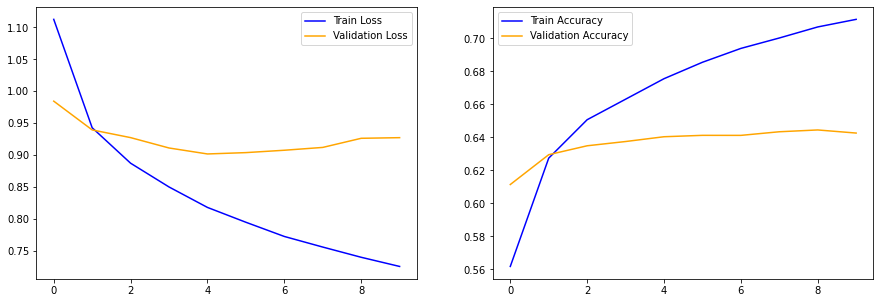

In [61]:
X_train, X_val, Y_train, Y_val = train_test_split(train_seq, Y_train, test_size=0.3333)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=64)

print(f'[INFO] Saving model weights into {WEIGHTS_DIR}/{BASIC_CNN_MODEL_NAME}.weights.hdf5')
model.save_weights(f'{WEIGHTS_DIR}/{BASIC_CNN_MODEL_NAME}.weights.hdf5')

### Visualizing training results ###
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(val_loss, label='Validation Loss', color='orange')
ax[0].legend()

ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(val_acc, label='Validation Accuracy', color='orange')
ax[1].legend()
plt.show()

# Build more complex CNN with multiple Conv layers

In [39]:
def make_complex_cnn_model(input_shape, vocab_size):
    kernel_sizes = [2,3,4,5,6]
    inputs = Input(shape=input_shape[1:])
    embs   = Embedding(vocab_size, 128, input_length=input_shape[1])(inputs)
    embs   = Reshape(target_shape=(input_shape[1], 128))(embs)
    
    convs = []
    for kernel_size in kernel_sizes:
        conv1d = Conv1D(filters=32, kernel_size=kernel_size, padding='same', activation='relu',
                       kernel_regularizer=l1(1e-4))(embs)
        # pool1d = MaxPool1D(pool_size=2)(conv1d)
        relu = LeakyReLU(0.02)(conv1d)
        output = Dropout(0.3)(relu)

        convs.append(output)
    
    concat = Concatenate(axis=1)(convs)
    # return_sequences : whether to return the full sequence of output or only the last output in the sequence
    # return_sequences is defaulted as False.
    rnn    = LSTM(128, return_sequences=False, dropout=0.2,recurrent_dropout=0.2)(concat)
    logits = Dense(num_classes)(rnn)
    output = Activation("softmax")(logits)
    
    model  = Model(inputs=inputs, outputs=output, name=COMPLEX_CNN_MODEL_NAME)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = make_complex_cnn_model(train_seq.shape, vocab_size)
print(model.summary())

print(f"[INFO] Saving model into {MODELS_DIR}/{COMPLEX_CNN_MODEL_NAME}.h5")
model.save(f'{MODELS_DIR}/{COMPLEX_CNN_MODEL_NAME}.h5')

Model: "complex_cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 30, 128)      640000      input_11[0][0]                   
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 30, 128)      0           embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 30, 32)       8224        reshape_10[0][0]                 
________________________________________________________________________________________

In [40]:
X_train, X_val, Y_train, Y_val = train_test_split(train_seq, Y_train, test_size=0.3333)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=64)

print(f'[INFO] Saving model weights into {WEIGHTS_DIR}/{COMPLEX_CNN_MODEL_NAME}.weights.hdf5')
model.save_weights(f'{WEIGHTS_DIR}/{COMPLEX_CNN_MODEL_NAME}.weights.hdf5')

### Visualizing training results ###
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(val_loss, label='Validation Loss', color='orange')
ax[0].legend()

ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(val_acc, label='Validation Accuracy', color='orange')
ax[1].legend()
plt.show()

Epoch 1/10
1626/1626 [==============================] - 370s 227ms/step - loss: 1.1674 - accuracy: 0.5493 - val_loss: 1.0654 - val_accuracy: 0.5872
Epoch 2/10
1626/1626 [==============================] - 366s 225ms/step - loss: 1.0266 - accuracy: 0.6094 - val_loss: 0.9759 - val_accuracy: 0.6281
Epoch 3/10
1626/1626 [==============================] - 371s 228ms/step - loss: 0.9382 - accuracy: 0.6406 - val_loss: 0.9456 - val_accuracy: 0.6352
Epoch 4/10
1626/1626 [==============================] - 368s 226ms/step - loss: 0.9005 - accuracy: 0.6535 - val_loss: 0.9383 - val_accuracy: 0.6340
Epoch 5/10
1511/1626 [==========================>...] - ETA: 22s - loss: 0.8707 - accuracy: 0.6665

KeyboardInterrupt: 

In [51]:
# Build a simple Bidirectional LSTM model
def make_simple_cnn_model(input_shape, vocab_size):
    inputs = Input(shape=input_shape[1:])
    embs   = Embedding(vocab_size, 32, input_length=input_shape[1])(inputs)
    embs   = Reshape(target_shape=(input_shape[1], 32))(embs)
    
    rnn = Bidirectional(LSTM(64, return_sequences=True))(embs)
    rnn = Bidirectional(LSTM(64))(rnn)
    
    logits = Dense(5)(rnn)
    output = Activation("sigmoid")(logits)
    
    model = Model(inputs=inputs, outputs=output, name=BASIC_BIRNN_MODEL_NAME)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

train_seq = train_seq.reshape(-1, train_seq.shape[1], 1)
test_seq  = test_seq.reshape(-1, test_seq.shape[1], 1)
model = make_simple_cnn_model(train_seq.shape, vocab_size)

print(model.summary())
print(f'[INFO] Saving model into {MODELS_DIR}/{BASIC_BIRNN_MODEL_NAME}.h5')
model.save(f'{MODELS_DIR}/{BASIC_BIRNN_MODEL_NAME}.h5')

Model: "basic_birnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 30, 1)]           0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 30, 1, 32)         160000    
_________________________________________________________________
reshape_13 (Reshape)         (None, 30, 32)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 128)           49664     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 645       
_________________________________________________________________
activation_12 (Activation)   (None, 5)                 

In [52]:
X_train, X_val, Y_train, Y_val = train_test_split(train_seq, Y_train, test_size=0.3333)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=64)

print(f'[INFO] Saving model weights into {WEIGHTS_DIR}/{BASIC_BIRNN_MODEL_NAME}.weights.hdf5')
model.save_weights(f'{WEIGHTS_DIR}/{BASIC_BIRNN_MODEL_NAME}.weights.hdf5')

### Visualizing training results ###
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(val_loss, label='Validation Loss', color='orange')
ax[0].legend()

ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(val_acc, label='Validation Accuracy', color='orange')
ax[1].legend()
plt.show()

Epoch 1/10
1626/1626 [==============================] - 10s 6ms/step - loss: 1.0777 - accuracy: 0.5697 - val_loss: 0.9431 - val_accuracy: 0.6186
Epoch 2/10
1626/1626 [==============================] - 10s 6ms/step - loss: 0.9097 - accuracy: 0.6343 - val_loss: 0.9085 - val_accuracy: 0.6335
Epoch 3/10
1626/1626 [==============================] - 10s 6ms/step - loss: 0.8624 - accuracy: 0.6533 - val_loss: 0.8933 - val_accuracy: 0.6432
Epoch 4/10
1626/1626 [==============================] - 10s 6ms/step - loss: 0.8298 - accuracy: 0.6649 - val_loss: 0.8874 - val_accuracy: 0.6429
Epoch 5/10
1626/1626 [==============================] - 10s 6ms/step - loss: 0.8057 - accuracy: 0.6762 - val_loss: 0.8920 - val_accuracy: 0.6469
Epoch 6/10
1626/1626 [==============================] - 10s 6ms/step - loss: 0.7845 - accuracy: 0.6838 - val_loss: 0.8935 - val_accuracy: 0.6442
Epoch 7/10
1452/1626 [=========================>....] - ETA: 0s - loss: 0.7628 - accuracy: 0.6931

KeyboardInterrupt: 